In [92]:
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import differential_evolution

n = 100

## Пункт а

##### Хи квадрат

In [101]:
chi2_pval = float(st.chi2.sf(16.4, 9))
print(f"{chi2_pval = }")

chi2_pval = 0.058984030544419454


##### Колмогоров

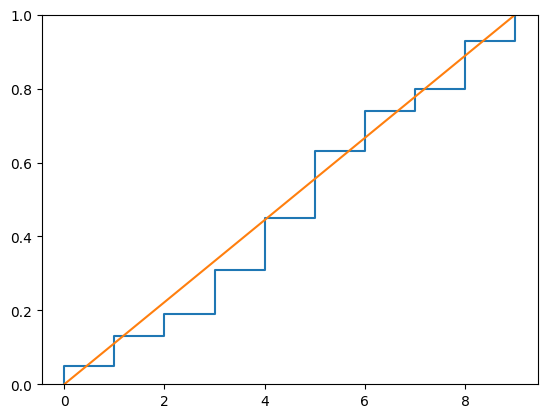

In [104]:
count = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
sample = []
for i in range(len(count)):
    sample += [i]*count[i]

x = np.linspace(0, 9, 10)
ecdf = np.append([0], st.ecdf(sample).cdf.probabilities)
cdf = st.uniform.cdf(x, loc=0, scale=9)

plt.ecdf(sample)
plt.plot(x, cdf)

In [95]:
kolmogorov_delta = np.sqrt(n) * np.max(np.abs(
    np.append(
        cdf - ecdf[:10],
        cdf - ecdf[1:]
    )
))
kolmogorov_delta = float(kolmogorov_delta)

kolmogorov_pval = 0
for i in range(1, 100_000):
    kolmogorov_pval += ((-1)**(i + 1)) * np.exp(-2 * (i**2) * (kolmogorov_delta**2))
kolmogorov_pval = float(2 * kolmogorov_pval)

print(
    f"{kolmogorov_delta = }",
    f"{kolmogorov_pval = }",
    sep="\n"
)

kolmogorov_delta = 1.4333333333333331
kolmogorov_pval = 0.03285188543859743


## Пункт b

##### Хи квадрат

In [96]:
m_i = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]

def func(x):
    global m_i
    
    loc = x[0]
    scale = x[1]

    p_i = st.norm.cdf([1, 2, 3, 4, 5, 6, 7, 8, 9], loc=loc, scale=scale)
    product = 1
    for i in range(8):
        product *= (p_i[i + 1] - p_i[i]) ** m_i[i + 1]

    return - (p_i[0] ** m_i[0] * (1 - p_i[-1]) ** m_i[-1] * product)


res = differential_evolution(
    func=func,
    bounds=[(3, 7), (1, 4)],
    maxiter=10_000,
)

theta_1 = float(res.x[0])
theta_2 = float(res.x[1])

p_i = st.norm.cdf([1, 2, 3, 4, 5, 6, 7, 8, 9], loc=theta_1, scale=theta_2)

np_i = []
np_i.append(n * p_i[0])
for i in range(8):
    np_i.append(n * (p_i[i + 1] - p_i[i]))
np_i.append(n * (1 - p_i[-1]))

np_i = np.array(np_i)

print(
    f"{theta_1 = }",
    f"{theta_2 = }",
    f"\n{np_i = }",
    sep="\n"
)

theta_1 = 5.2886351124187385
theta_2 = 2.678593475626779

np_i = array([ 5.46799037,  5.50910743,  8.66660833, 11.87904563, 14.18670178,
       14.76218238, 13.38410454, 10.57296377,  7.27730445,  8.29399133])


In [ ]:
chi2_delta = float(np.sum((np_i - m_i) ** 2 / np_i))
chi2_pval = float(st.chi2.sf(chi2_delta, 7))

print(
    f"{chi2_delta = }",
    f"{chi2_pval = }",
    sep="\n"
)

chi2_delta = 9.805241887963016
chi2_pval = 0.19988151155269773


##### Колмогоров

In [ ]:
from collections.abc import Callable


def parametric_bootstrap(
    data: np.ndarray,
    statistic: Callable[[np.ndarray], float],
    prob_model: Callable[[int], np.ndarray],
    n_resamples: int = 10_000,
) -> np.ndarray:
    n = len(data)
    bootstrap_data = np.ndarray((n_resamples, ), dtype=np.float32)

    for i in range(n_resamples):
        resample = prob_model(n)
        bootstrap_data[i] = statistic(resample)
    
    bootstrap_data.sort()

    return bootstrap_data


def statistic(data):
    data = np.sort(data)

    mean = np.mean(data)
    std = np.std(data, ddof=1)

    ecdf = np.append([0], st.ecdf(data).cdf.probabilities)
    cdf = st.norm.cdf(data, loc=mean, scale=std)
    delta = np.sqrt(n) * np.max(np.abs(
        np.append(
            cdf - ecdf[:len(ecdf) - 1],
            cdf - ecdf[1:]
        )
    ))

    return delta


mean = np.mean(sample)
std = np.std(sample, ddof=1)
n_resamples = 50_000
bootstrap = parametric_bootstrap(
    sample,
    statistic,
    lambda n: np.random.normal(mean, std, n),
    n_resamples=n_resamples,
)

x = np.linspace(0, 9, 10)
ecdf = np.append([0], st.ecdf(sample).cdf.probabilities)
cdf = st.norm.cdf(x, loc=mean, scale=std)
kolmogorov_delta = np.sqrt(n) * np.max(np.abs(
    np.append(
        cdf - ecdf[:10],
        cdf - ecdf[1:]
    )
))
kolmogorov_delta = float(kolmogorov_delta)

kolmogorov_pval = np.count_nonzero(bootstrap >= kolmogorov_delta) / n_resamples

print(
    f"{kolmogorov_delta = }",
    f"{kolmogorov_pval = }",
    sep="\n"
)

kolmogorov_delta = 1.0020942299329128
kolmogorov_pval = 0.01506
